
Training with configuration: Deep_Gini_Small

--- Iteration 1 ---
Added 2414 pseudo-labels | Total labeled: 3050

--- Iteration 2 ---
Added 93 pseudo-labels | Total labeled: 3143

--- Iteration 3 ---
Added 10 pseudo-labels | Total labeled: 3153

--- Iteration 4 ---
No high-confidence samples. Stopping.


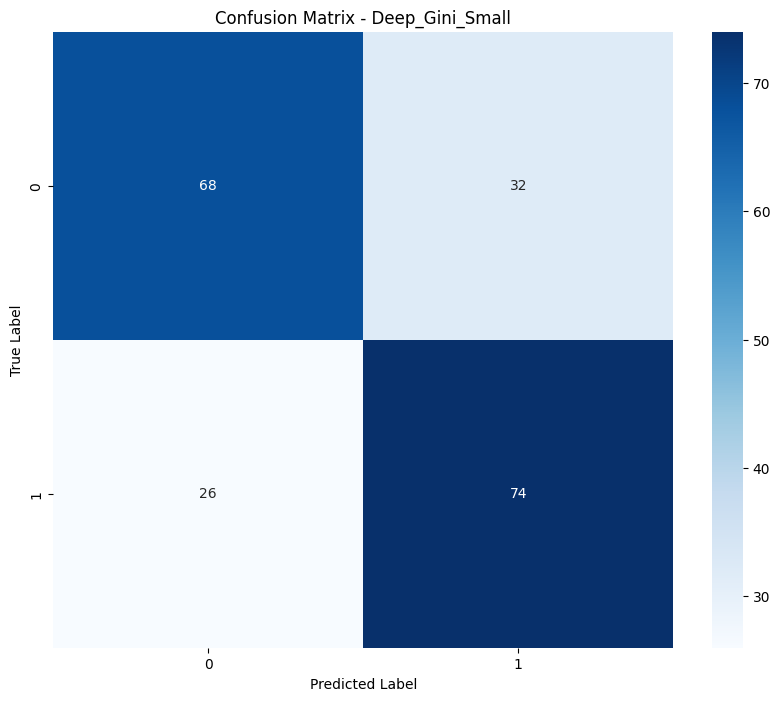


Training with configuration: Deep_Gini_Large

--- Iteration 1 ---
Added 1594 pseudo-labels | Total labeled: 2230

--- Iteration 2 ---
Added 295 pseudo-labels | Total labeled: 2525

--- Iteration 3 ---
Added 252 pseudo-labels | Total labeled: 2777

--- Iteration 4 ---
Added 62 pseudo-labels | Total labeled: 2839

--- Iteration 5 ---
Added 34 pseudo-labels | Total labeled: 2873


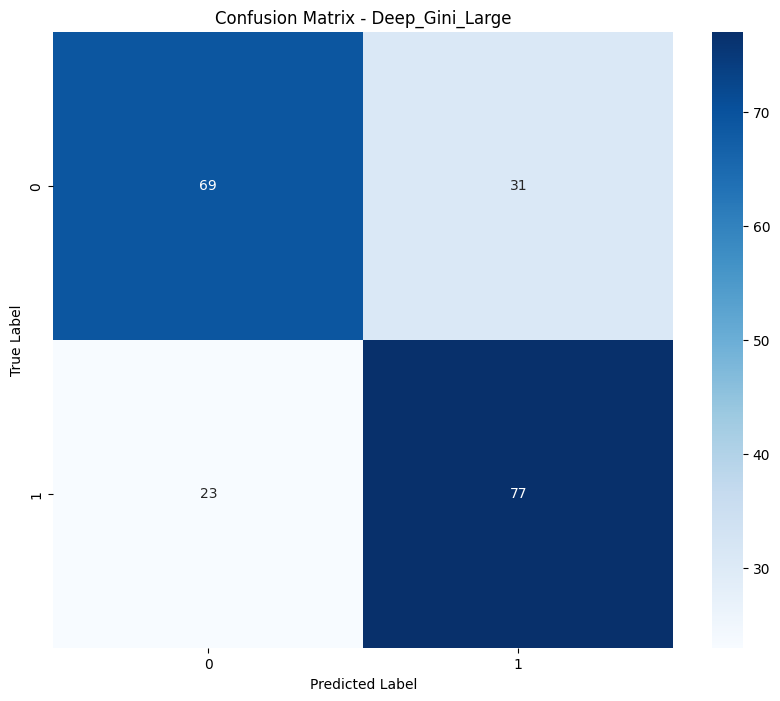


Training with configuration: Medium_Gini_Small

--- Iteration 1 ---
Added 2421 pseudo-labels | Total labeled: 3057

--- Iteration 2 ---
Added 89 pseudo-labels | Total labeled: 3146

--- Iteration 3 ---
Added 4 pseudo-labels | Total labeled: 3150

--- Iteration 4 ---
Added 1 pseudo-labels | Total labeled: 3151

--- Iteration 5 ---
No high-confidence samples. Stopping.


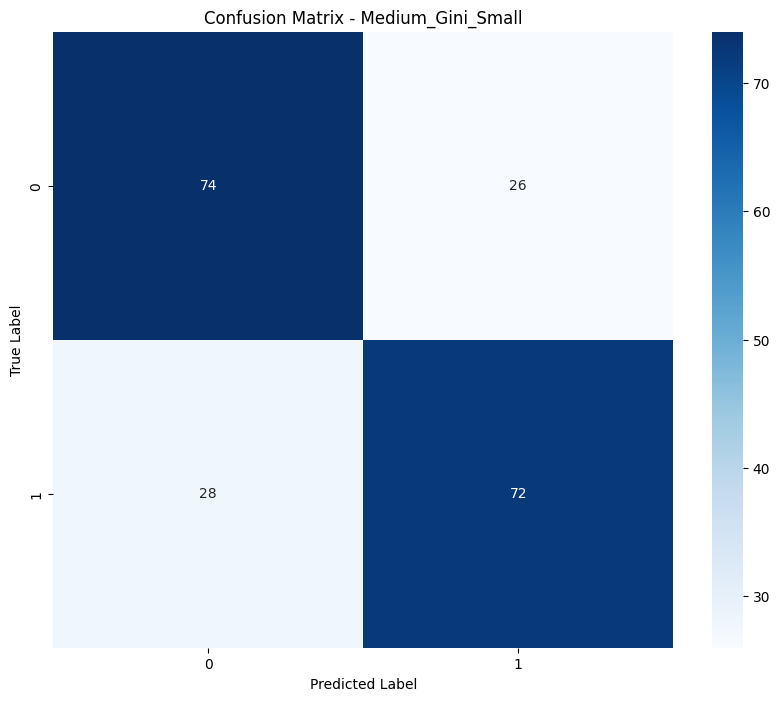


Training with configuration: Shallow_Gini_Small

--- Iteration 1 ---
Added 1948 pseudo-labels | Total labeled: 2584

--- Iteration 2 ---
Added 56 pseudo-labels | Total labeled: 2640

--- Iteration 3 ---
No high-confidence samples. Stopping.


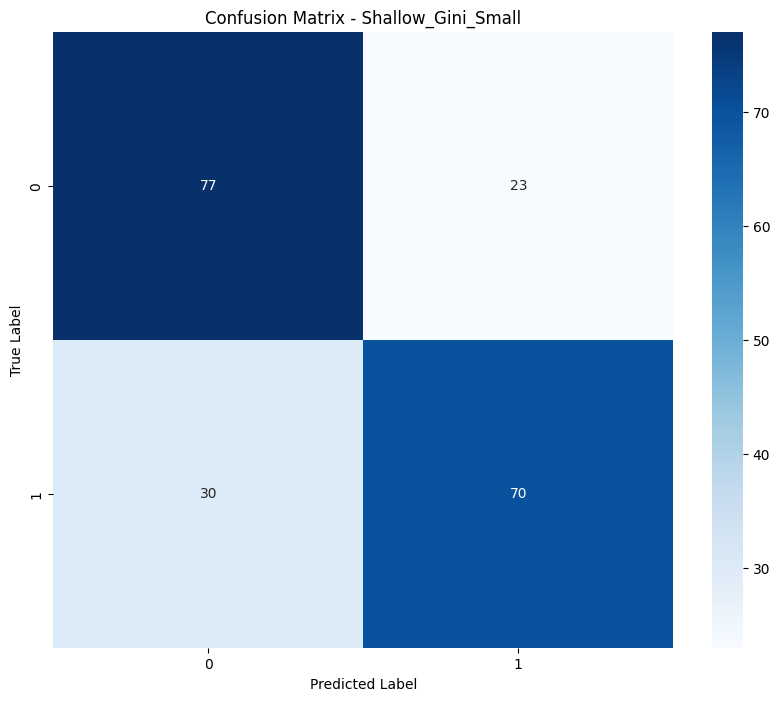


Training with configuration: Deep_Entropy_Small

--- Iteration 1 ---
Added 2451 pseudo-labels | Total labeled: 3087

--- Iteration 2 ---
Added 93 pseudo-labels | Total labeled: 3180

--- Iteration 3 ---
Added 3 pseudo-labels | Total labeled: 3183

--- Iteration 4 ---
No high-confidence samples. Stopping.


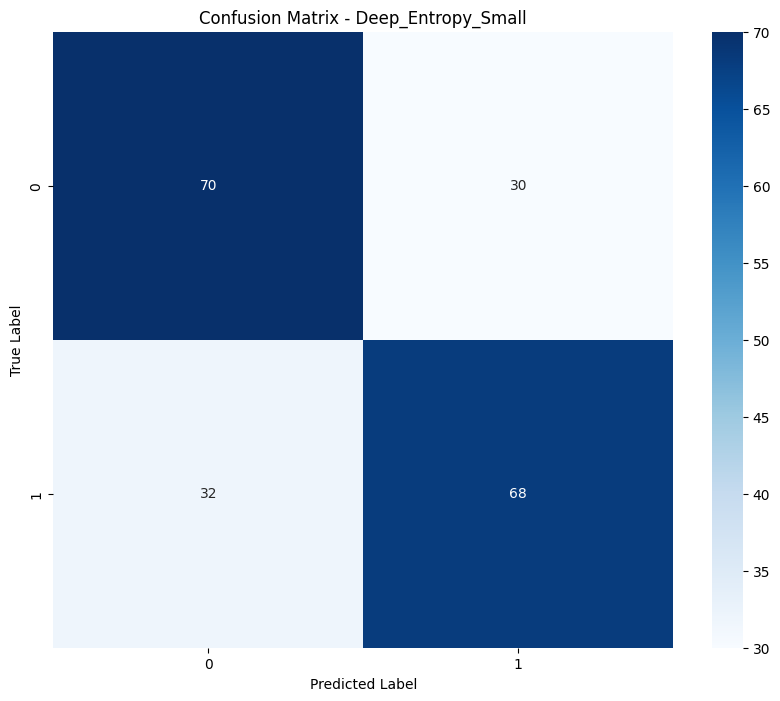


Training with configuration: Medium_Entropy_Small

--- Iteration 1 ---
Added 2040 pseudo-labels | Total labeled: 2676

--- Iteration 2 ---
Added 281 pseudo-labels | Total labeled: 2957

--- Iteration 3 ---
Added 141 pseudo-labels | Total labeled: 3098

--- Iteration 4 ---
Added 25 pseudo-labels | Total labeled: 3123

--- Iteration 5 ---
Added 39 pseudo-labels | Total labeled: 3162


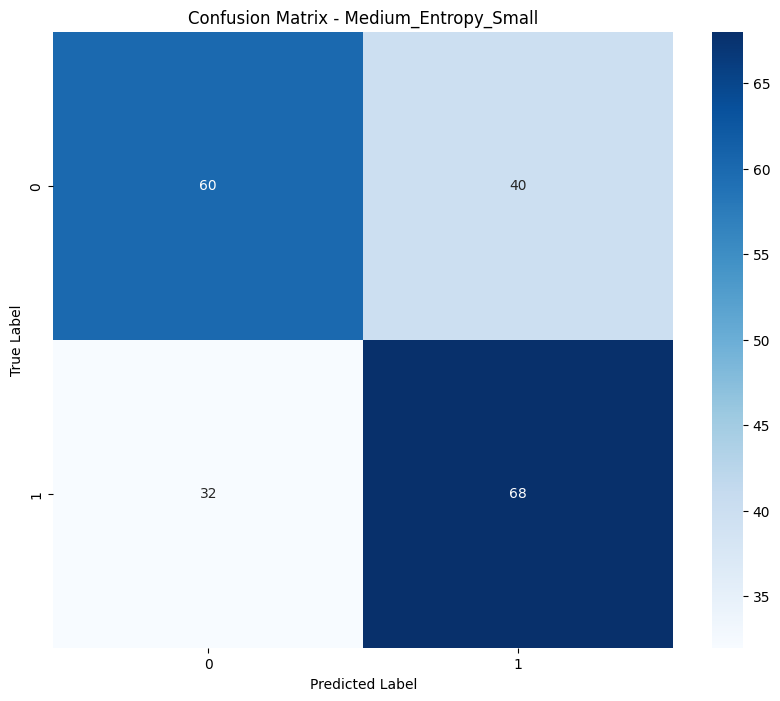


                        SEMI-SUPERVISED LEARNING RESULTS                        
Model Name                Accuracy   Total Samples   Pseudo-labeled  Description                             
--------------------------------------------------------------------------------
Shallow_Gini_Small        0.7350     2640            2004            Shallow tree with Gini impurity, small leaf
Deep_Gini_Large           0.7300     2873            2237            Deep tree with Gini impurity, large leaf
Medium_Gini_Small         0.7300     3151            2515            Medium tree with Gini impurity, small leaf
Deep_Gini_Small           0.7100     3153            2517            Deep tree with Gini impurity, small leaf
Deep_Entropy_Small        0.6900     3183            2547            Deep tree with entropy, small leaf      
Medium_Entropy_Small      0.6400     3162            2526            Medium tree with entropy, small leaf    

-------------------------------------------------------------

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load data from text files
def load_data(file_path):
    """Load image paths and labels from a dataset file."""
    paths, labels = [], []
    with open(file_path, 'r') as f:
        for line in f:
            img_path = line.strip()
            if os.path.exists(img_path):
                category = img_path.split('/')[1]  # Adjust based on your file structure
                paths.append(img_path)
                labels.append(category)
    return pd.DataFrame({'image': paths, 'label': labels})

# Load training and testing data
train_df = load_data("train.txt")
val_df = load_data("val.txt")

# Feature extraction (example: histogram features)
def compute_histogram_features(img_path):
    """Extracts histogram features from an image."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))  # Resize for consistency
    hist_features = [cv2.calcHist([img], [i], None, [256], [0, 256]).flatten() for i in range(3)]
    return np.concatenate(hist_features)

# Compute features for training and validation data
train_features = np.array([compute_histogram_features(path) for path in train_df['image']])
val_features = np.array([compute_histogram_features(path) for path in val_df['image']])

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
val_labels = label_encoder.transform(val_df['label'])

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

# Hyperparameter configurations for DecisionTree
# Hyperparameter configurations for DecisionTree
HYPERPARAM_CONFIGS = [
    {'name': 'Deep_Gini_Small', 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'class_weight': 'balanced', 'description': 'Deep tree with Gini impurity, small leaf'},
    {'name': 'Deep_Gini_Large', 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'description': 'Deep tree with Gini impurity, large leaf'},
    {'name': 'Medium_Gini_Small', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'class_weight': 'balanced', 'description': 'Medium tree with Gini impurity, small leaf'},
    {'name': 'Shallow_Gini_Small', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced', 'description': 'Shallow tree with Gini impurity, small leaf'},
    {'name': 'Deep_Entropy_Small', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'class_weight': 'balanced', 'description': 'Deep tree with entropy, small leaf'},
    {'name': 'Medium_Entropy_Small', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'class_weight': 'balanced', 'description': 'Medium tree with entropy, small leaf'}
]

# Store all metrics
all_metrics = []

for config in HYPERPARAM_CONFIGS:
    print(f"\n{'='*40}")
    print(f"Training with configuration: {config['name']}")
    print(f"{'='*40}")
    
    # Split into labeled and unlabeled data
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
        train_features,
        train_labels,
        test_size=0.80,
        random_state=42,
        stratify=train_labels
    )

    # Semi-supervised iterations
    max_iterations = 5
    high_confidence_threshold = 0.85
    
    current_X_labeled = X_labeled.copy()
    current_y_labeled = y_labeled.copy()
    current_X_unlabeled = X_unlabeled.copy()
    
    total_pseudo_labeled = 0
    
    for iteration in range(max_iterations):
        print(f"\n--- Iteration {iteration + 1} ---")
        
        # Initialize DecisionTree model with the current configuration
        model = DecisionTreeClassifier(
            criterion=config['criterion'],
            max_depth=config['max_depth'],
            min_samples_leaf=config['min_samples_leaf'],
            class_weight=config['class_weight'],
            random_state=42
        )
        
        # Train on labeled data
        model.fit(current_X_labeled, current_y_labeled)
        
        # Stop if no unlabeled data remains
        if len(current_X_unlabeled) == 0:
            print("No more unlabeled samples. Stopping.")
            break
            
        # Predict probabilities for unlabeled data
        y_probs = model.predict_proba(current_X_unlabeled)
        max_probs = np.max(y_probs, axis=1)
        
        # Select high-confidence predictions
        high_confidence_mask = max_probs >= high_confidence_threshold
        if not any(high_confidence_mask):
            print("No high-confidence samples. Stopping.")
            break
        
        high_confidence_indices = np.where(high_confidence_mask)[0]
        high_confidence_X = current_X_unlabeled[high_confidence_indices]
        high_confidence_y = model.predict(high_confidence_X)
        
        # Update datasets with pseudo-labeled samples
        current_X_labeled = np.vstack([current_X_labeled, high_confidence_X])
        current_y_labeled = np.concatenate([current_y_labeled, high_confidence_y])
        current_X_unlabeled = np.delete(current_X_unlabeled, high_confidence_indices, axis=0)
        
        num_added = len(high_confidence_X)
        total_pseudo_labeled += num_added
        
        print(f"Added {num_added} pseudo-labels | Total labeled: {len(current_X_labeled)}")

    # Final model training
    final_model = DecisionTreeClassifier(
        criterion=config['criterion'],
        max_depth=config['max_depth'],
        min_samples_leaf=config['min_samples_leaf'],
        class_weight=config['class_weight'],
        random_state=42
    )
    final_model.fit(current_X_labeled, current_y_labeled)
    
    # Evaluate on validation set
    y_pred = final_model.predict(val_features)
    accuracy = accuracy_score(val_labels, y_pred)
    report = classification_report(val_labels, y_pred, output_dict=True)
    
    # Store metrics
    metrics = {
        'config_name': config['name'],
        'accuracy': accuracy,
        'criterion': config['criterion'],
        'max_depth': config['max_depth'],
        'min_samples_leaf': config['min_samples_leaf'],
        'class_weight': str(config['class_weight']),
        'total_labeled': len(current_X_labeled),
        'pseudo_labeled': total_pseudo_labeled,
        'description': config['description']
    }
    all_metrics.append(metrics)
    
    # Save confusion matrix
    cm = confusion_matrix(val_labels, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {config["name"]}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Display results
print("\n" + "="*80)
print(f"{'SEMI-SUPERVISED LEARNING RESULTS':^80}")
print("="*80)
print(f"{'Model Name':<25} {'Accuracy':<10} {'Total Samples':<15} {'Pseudo-labeled':<15} {'Description':<40}")
print("-"*80)

if len(all_metrics) > 0:
    # Sort by accuracy in descending order
    sorted_metrics = sorted(all_metrics, key=lambda x: x['accuracy'], reverse=True)
    
    for metric in sorted_metrics:
        print(f"{metric['config_name']:<25} {metric['accuracy']:.4f}     {metric['total_labeled']:<15} {metric['pseudo_labeled']:<15} {metric['description']:<40}")
    
    # Highlight the best model
    best_model = sorted_metrics[0]
    print("\n" + "-"*80)
    print(f"Best model: {best_model['config_name']} with accuracy: {best_model['accuracy']:.4f}")
    print(f"Configuration: criterion={best_model['criterion']}, max_depth={best_model['max_depth']}, min_samples_leaf={best_model['min_samples_leaf']}")
    print("="*80)
else:
    print("No models were successfully trained and evaluated.")